In [1]:
from smokingml.datasets.nursing_dataset_v1 import produce_nursingv1_dataset_from_raw, NursingDatasetV1
from smokingml.datasets.nursing_dataset_v1.utils import get_all_session_ids, window_session
from smokingml.datasets.nursing_dataset_v1.dataloading import load_one_session, load_windowed_sessions
from pathlib import Path
import torch

In [ ]:
produce_nursingv1_dataset_from_raw(
    data_dir='../data/nursing_raw/',
    labels_dir='../data/nursing_labels_musa/',
    nursingv1_outdir='../data/nursingv1_dataset'
)

In [11]:
nursingv1_dir = Path('../data/nursingv1_dataset/')
ids = get_all_session_ids(nursingv1_dir)[:10]
dataset = NursingDatasetV1(nursingv1_dir, ids)

In [6]:
session,labels = load_one_session(nursingv1_dir, 0)
X = window_session(session)

torch.Size([28600, 303])

Prototyping:

In [2]:
import pandas as pd
import torch
from pathlib import Path
from tqdm import tqdm
import json
from torch import nn

In [3]:
working_dir = Path('../data')
data_dir = Path(working_dir / 'nursing_raw')
labels_dir = Path(working_dir / 'nursing_labels_musa')
nursingv1_outdir = Path(working_dir / 'nursingv1_dataset')
# nursingv1_outdir.mkdir()
DM_FACTOR = 5
WINSIZE = 101

In [4]:
# Read json labels and get list of which sessions are labelled

json_labels = {}    # labels for each labelled session
for file in labels_dir.iterdir():

    # Get session index from label filename
    session_idx = int(file.name.split('_')[0])

    # Read json and save it if session is labelled
    with file.open() as f:
        doc = json.load(f)

        # If the "puffs" key exists in the json document, the session has been labelled
        if doc.get('puffs'):
            json_labels[session_idx] = doc

  0%|          | 0/58 [00:00<?, ?it/s]

x torch.Size([3, 31200])
y torch.Size([31100, 1])
xp torch.Size([31300, 3])
yp torch.Size([31200, 1])
torch.Size([31200, 1])
torch.Size([31300, 1])


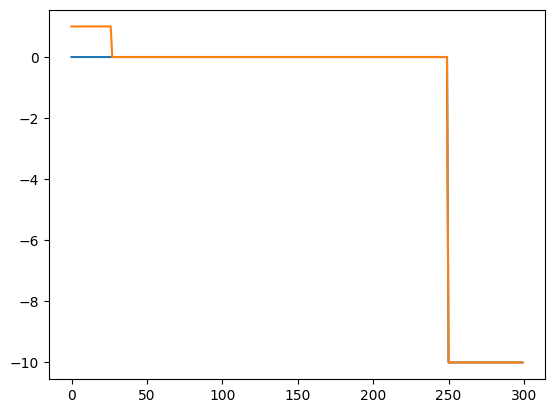

In [13]:
# pbar = tqdm(json_labels.items())
pbar = tqdm(json_labels.items())
for session_idx, y_json in pbar:

    ## Get X from csv
    # Read x,y,z data for this session
    data_df = pd.read_csv(
        data_dir / f'{session_idx}' / 'raw_data.csv', 
        header=None,
        usecols=[2,3,4]
    )[::DM_FACTOR]

    # Save data as torch tensor, with x,y,z as rows and each datapoint as columns
    X = torch.tensor(data_df.values).T

    ## Get y from json labels
    y = torch.zeros(len(X[0]) - WINSIZE + 1).reshape([-1,1])   
    for puff in y_json['puffs']:

        # Get start and stop of puff, in same frequency as data
        puff_start = puff['start'] // DM_FACTOR
        puff_end = puff['end'] // DM_FACTOR

        # All windows whose center is within puff get y of 1
        # All windows `WINSIZE//2` before start and end have a center within puff
        puff_start_idx = max(puff_start - WINSIZE//2, 0)
        puff_end_idx = max(puff_end - WINSIZE//2, 0)

        y[puff_start_idx:puff_end_idx] = 1

    ## Save X and y in dataset
    session_outdir = nursingv1_outdir / f'{session_idx}'
    Path(session_outdir).mkdir()
    
    # Save X and y
    torch.save(X, session_outdir / 'X.pt')
    torch.save(y, session_outdir / 'y.pt')
    
    # Save size of session
    torch.save(X.shape, session_outdir / 'Xshape.pt')

    # # Save X of each session in files of size 5000 for less file overhead
    # for i in range(0, len(X[0], 5000)):
    #     end_idx = min(len(X[0:], )
    #     torch.save(
    #         X[]
    #     )
    # torch.save(
    #     TensorDataset(X,y),
    #     f'{len(X[0])}.pt'       # use length of session as filename
    # )

In [108]:
X = torch.cat([torch.ones(100,1)*-1, torch.ones(100,1)*-1, torch.ones(100,1)*-1], axis=1)
X[0:20, :] = torch.ones(3) * 2
X[40:70, :] = torch.ones(3) * 2

y_json = {
    'puffs': [
        {
            'start': 0,
            'end': 20
        },
        {
            "start": 40,
            "end": 70
        }
    ]
}

winsize = 11
Xpad = nn.functional.pad(X, (0,0,winsize//2,winsize//2))

y = torch.zeros(len(Xpad) - (winsize - 1), 1)
for puff in y_json['puffs']:
    start = puff['start']
    end = puff['end']

    # If index of this window is within range(start, end), then its 
    # center point is within the original puff (before padding)
    start_idx = max(start, 0)
    end_idx = max(end, 0)

    y[start_idx:end_idx] = 1


# Window Xpad:

session = Xpad
x_acc = session[:,0].unsqueeze(1)
y_acc = session[:,1].unsqueeze(1)
z_acc = session[:,2].unsqueeze(1)
# x_acc = session[0].reshape(-1, 1)
# y_acc = session[1].reshape(-1, 1)
# z_acc = session[2].reshape(-1, 1)

w = winsize-1

xs = [x_acc[:-w]]
ys = [y_acc[:-w]]
zs = [z_acc[:-w]]

for i in range(1,w):
    xs.append(x_acc[i:i-w])
    ys.append(y_acc[i:i-w])
    zs.append(z_acc[i:i-w])

xs.append(x_acc[w:])
ys.append(y_acc[w:])
zs.append(z_acc[w:])

xs = torch.cat(xs,axis=1).float()
ys = torch.cat(ys,axis=1).float()
zs = torch.cat(zs,axis=1).float()

xs[-1], y[-1]
# X = torch.cat([xs,ys,zs], axis=1)

# fig = plt.figure(1)
# ax = fig.add_subplot(111)
# plt.minorticks_on()
# plt.grid(visible=True, which='major')
# plt.grid(visible=True, which='minor')
# ax.grid(True)
# plt.plot(X[:,0])
# plt.plot(y[:,0])
# plt.plot(Xpad[:,0])

torch.Size([100, 1])